# Préambule
___

In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge


from utils.financial_tools import sharpe_ratio

np.random.seed(42)

## Handling the data
___

In [2]:
# Load the data
file_path = "data/high_10m.parquet"

table1 = pd.read_parquet(file_path)

In [3]:
table1.head()

,DATE,SYMBOL,TIME,ALL_EX,MID_OPEN,SUM_DELTA,RETURN
0,2021-12-01,A,09:30:00,DNYBTJVPCZUKXHA,152.190,-8.401819,0.000000
1,2021-12-01,A,09:40:00,PBTJVDZUYKNHCXM,150.490,0.473357,-0.011170
2,2021-12-01,A,09:50:00,KDPBTJVNZUCXYH,151.475,-10.867709,0.006545
3,2021-12-01,A,10:00:00,DABTJNKYVPZUXCH,150.510,-0.125414,-0.006371
4,2021-12-01,A,10:10:00,DVJTPNKUZYACBXHM,151.960,-1.274648,0.009634


In [4]:
# Create a timestamp column
table1['timestamp'] = pd.to_datetime(table1['DATE'].dt.strftime('%Y-%m-%d') + ' ' + table1['TIME'])
table1 = table1.set_index('timestamp')

In [5]:
table1 = table1.drop(['DATE', 'TIME'], axis=1, errors='ignore')

In [6]:
table1

,SYMBOL,ALL_EX,MID_OPEN,SUM_DELTA,RETURN
timestamp,,,,,
2021-12-01 09:30:00,A,DNYBTJVPCZUKXHA,152.190,-8.401819,0.000000
2021-12-01 09:40:00,A,PBTJVDZUYKNHCXM,150.490,0.473357,-0.011170
2021-12-01 09:50:00,A,KDPBTJVNZUCXYH,151.475,-10.867709,0.006545
2021-12-01 10:00:00,A,DABTJNKYVPZUXCH,150.510,-0.125414,-0.006371
2021-12-01 10:10:00,A,DVJTPNKUZYACBXHM,151.960,-1.274648,0.009634
...,...,...,...,...,...
2021-12-31 15:00:00,ZYXI,DVJPQUZN,10.055,-0.050725,-0.006914
2021-12-31 15:10:00,ZYXI,DQKJVUZ,10.040,-0.032836,-0.001492
2021-12-31 15:20:00,ZYXI,QNKUZPDJV,10.040,-0.059878,0.000000


In [7]:
df_copy = table1.copy()

In [8]:
# Create the lags for each stock
lags = 10
train_window = 50

lag_columns = [f'return_lag_{i}' for i in range(1, lags+1)]
features = lag_columns

for i,lag in enumerate(lag_columns):
    df_copy[lag] = df_copy.groupby('SYMBOL')['RETURN'].shift(i+1)

# Drop NaN values
df_copy = df_copy.dropna()

df_copy.head(5)

,SYMBOL,ALL_EX,MID_OPEN,SUM_DELTA,RETURN,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5,return_lag_6,return_lag_7,return_lag_8,return_lag_9,return_lag_10
timestamp,,,,,,,,,,,,,,,
2021-12-01 11:10:00,A,CDNZJBTUVPKHYX,151.390,-3.817502,0.001389,-0.001288,0.002550,-0.002214,-0.003063,-0.001119,0.009634,-0.006371,0.006545,-0.011170,0.000000
2021-12-01 11:20:00,A,ZDBNPKTJYVUHACX,151.545,-4.071874,0.001024,0.001389,-0.001288,0.002550,-0.002214,-0.003063,-0.001119,0.009634,-0.006371,0.006545,-0.011170
2021-12-01 11:30:00,A,PTNYZJKVDHBXCUM,151.740,-2.055611,0.001287,0.001024,0.001389,-0.001288,0.002550,-0.002214,-0.003063,-0.001119,0.009634,-0.006371,0.006545
2021-12-01 11:40:00,A,NDTPKYJBVZUHCXA,152.035,-0.662029,0.001944,0.001287,0.001024,0.001389,-0.001288,0.002550,-0.002214,-0.003063,-0.001119,0.009634,-0.006371
2021-12-01 11:50:00,A,PNKZTBXJYVDCUA,152.365,-2.513064,0.002171,0.001944,0.001287,0.001024,0.001389,-0.001288,0.002550,-0.002214,-0.003063,-0.001119,0.009634


In [9]:
table1 = df_copy
del df_copy

table1.head(2)

,SYMBOL,ALL_EX,MID_OPEN,SUM_DELTA,RETURN,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5,return_lag_6,return_lag_7,return_lag_8,return_lag_9,return_lag_10
timestamp,,,,,,,,,,,,,,,
2021-12-01 11:10:00,A,CDNZJBTUVPKHYX,151.390,-3.817502,0.001389,-0.001288,0.002550,-0.002214,-0.003063,-0.001119,0.009634,-0.006371,0.006545,-0.011170,0.00000
2021-12-01 11:20:00,A,ZDBNPKTJYVUHACX,151.545,-4.071874,0.001024,0.001389,-0.001288,0.002550,-0.002214,-0.003063,-0.001119,0.009634,-0.006371,0.006545,-0.01117


In [10]:
# Take some random stocks
nb_random_stocks = 100
list_of_symbols = table1['SYMBOL'].unique()

random_stocks = np.random.choice(list_of_symbols, nb_random_stocks)
table2 = table1[table1['SYMBOL'].isin(random_stocks)]

## Useful functions
___

In [11]:
def rolling_sampling(data: pd.DataFrame, train_window: int = 6):
    """
    Generates rolling window splits for time series training and testing.

    This function creates temporal splits using a rolling window approach for training
    and testing data. It works with a timestamp-indexed Pandas DataFrame and a fixed
    window size.

    Args:
        data: Input Pandas DataFrame with temporal index.
        train_window: Number of time intervals for the training window.
                     Represents how many historical data points are used
                     for training. Default: 6 intervals.

    Returns:
        A tuple containing two lists:
        - splitting_train: List of temporal indices for each training window
        - splitting_test: List of temporal indices for each corresponding test point

    Example:
        >>> df = pd.DataFrame(...) # DataFrame with temporal index
        >>> train_splits, test_splits = rolling_sampling(df, train_window=10)
    """

    list_of_dates = data.index.unique()
    number_of_splits = len(list_of_dates) - train_window

    splitting_train = []  # Initialize as empty lists
    splitting_test = []

    for split in range(number_of_splits):
        # Append date ranges as lists to splitting_train
        splitting_train.append(list_of_dates[split : split + train_window])
        # Append single dates to splitting_test
        splitting_test.append(list_of_dates[split + train_window])

    return splitting_train, splitting_test

# Linear Regression
___

In [12]:
from sklearn.linear_model import LinearRegression

def run_regression_for_symbol(symbol, group, features=features, train_window=train_window):
    group = group.sort_values("timestamp")
    splitting_train, splitting_test = rolling_sampling(group, train_window)

    results = []

    for slice_train, slice_test in zip(splitting_train, splitting_test):
        window_data = group.loc[slice_train.union([slice_test])]

        X = window_data[features]
        y = window_data['RETURN']

        X_train = X.iloc[:-1]
        X_test = X.iloc[[-1]]

        y_train = y.iloc[:-1].values
        y_test = y.iloc[-1]

        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        results.append({
            'symbol': symbol,
            'timestamp': slice_test,
            'y_true': y_test,
            'y_pred': y_pred[0],
            'managed_return': y_pred[0] * y_test
        })

    return results


In [13]:
# Run in parallel
results_nested = Parallel(n_jobs=-1)(
    delayed(run_regression_for_symbol)(
        symbol, group, features=features, train_window=train_window
    )
    for symbol, group in tqdm.tqdm(table2.groupby("SYMBOL"))
)

# Flatten the list of lists
results = [item for sublist in results_nested for item in sublist]

# Convert to DataFrame
df_predictions = pd.DataFrame(results).set_index(['symbol', 'timestamp'])

100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


## Scores

In [14]:
r2 = r2_score(df_predictions['y_true'], df_predictions['y_pred'])
mae = mean_absolute_error(df_predictions['y_true'], df_predictions['y_pred'])

print(f"Overall R²: {r2:.4f}")
print(f"Overall MAE: {mae:.6f}")

Overall R²: -3.4536
Overall MAE: 0.003958


## Managed returns

In [15]:
# Our strategy returns
realized_returns = df_predictions[['managed_return']].groupby(level=1).mean()
df_cum = realized_returns.cumsum()

# Market benchmark
real_returns = df_predictions[['y_true']].groupby(level=1).mean()
df_real_cum = real_returns.cumsum()

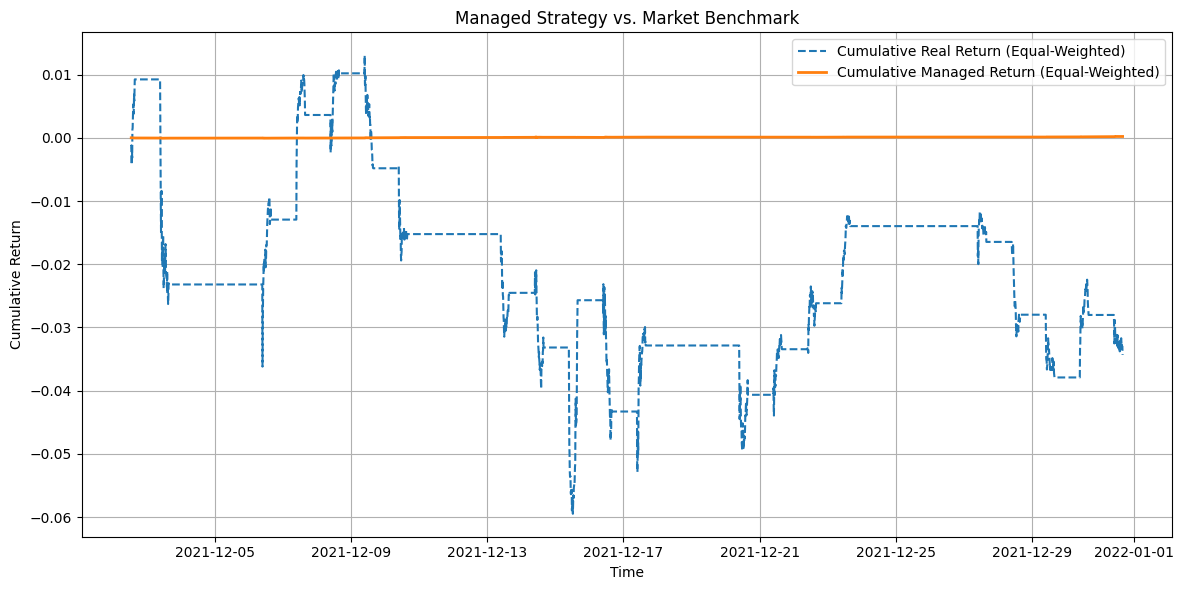

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df_real_cum, label="Cumulative Real Return (Equal-Weighted)", linestyle="--")
plt.plot(df_cum, label="Cumulative Managed Return (Equal-Weighted)", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Managed Strategy vs. Market Benchmark")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
tmp = df_predictions[['y_true','managed_return']].groupby(level=1).mean()
tmp = tmp/tmp.std()

sr = sharpe_ratio(tmp)

In [18]:
print(sr)

y_true           -0.08
managed_return    0.17
dtype: float64


# Ridge regression (non-random)
___

In [19]:
shrinkage_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

def run_ridge_for_symbol(symbol, group, features=features, train_window=train_window, shrinkage_list=shrinkage_list):
    group = group.sort_values("timestamp")
    splitting_train, splitting_test = rolling_sampling(group, train_window)

    results = []

    for slice_train, slice_test in zip(splitting_train, splitting_test):
        window_data = group.loc[slice_train.union([slice_test])]
        X = window_data[features]
        y = window_data['RETURN']

        X_train = X.iloc[:-1]
        X_test = X.iloc[[-1]]
        y_train = y.iloc[:-1]
        y_test = y.iloc[-1]

        for alpha in shrinkage_list:
            clf = Ridge(alpha=alpha)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            results.append({
                'symbol': symbol,
                'timestamp': slice_test,
                'alpha': alpha,
                'y_true': y_test,
                'y_pred': y_pred[0],
                'managed_return': y_pred[0] * y_test,
            })

    return results

In [20]:
# Run in parallel over all symbols
results = Parallel(n_jobs=-1)(
    delayed(run_ridge_for_symbol)(symbol, group, features=features, train_window= train_window, shrinkage_list=shrinkage_list)
    for symbol, group in tqdm.tqdm(table2.groupby("SYMBOL"))
)
# Flatten the nested list of predictions
results = [item for sublist in results for item in sublist]

# Convert to DataFrame
df_predictions = pd.DataFrame(results).set_index(['symbol', 'timestamp'])

100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


## Scores

In [21]:
r2 = r2_score(df_predictions['y_true'], df_predictions['y_pred'])
mae = mean_absolute_error(df_predictions['y_true'], df_predictions['y_pred'])

print(f"Overall R²: {r2:.4f}")
print(f"Overall MAE: {mae:.6f}")

Overall R²: -0.1881
Overall MAE: 0.003192


## Managed returns

In [22]:
df_predictions = df_predictions.reset_index()

In [23]:
# Market benchmark
df_market_returns = df_predictions.groupby('timestamp')['y_true'].mean()
df_market_returns.head(5)

timestamp
2021-12-02 13:10:00   -0.001343
2021-12-02 13:20:00    0.000143
2021-12-02 13:30:00   -0.003066
2021-12-02 13:40:00    0.002871
2021-12-02 13:50:00   -0.001800
Name: y_true, dtype: float64

In [24]:
# Our strategy returns
df_market_timing = df_predictions[['symbol','timestamp','alpha','y_pred','managed_return']]

In [25]:
df_market_timing = pd.pivot_table(df_market_timing, values=['managed_return'], index=['symbol', 'timestamp'],
                       columns=['alpha'], aggfunc="mean")

In [26]:
df_market_timing = df_market_timing.groupby(level=1).mean()

In [27]:
tmp = pd.concat([df_market_returns,df_market_timing], axis = 1)
tmp = tmp/tmp.std()
sr = sharpe_ratio(tmp)

In [28]:
market_returns = tmp['y_true']
managed_returns = tmp.iloc[:,1:]

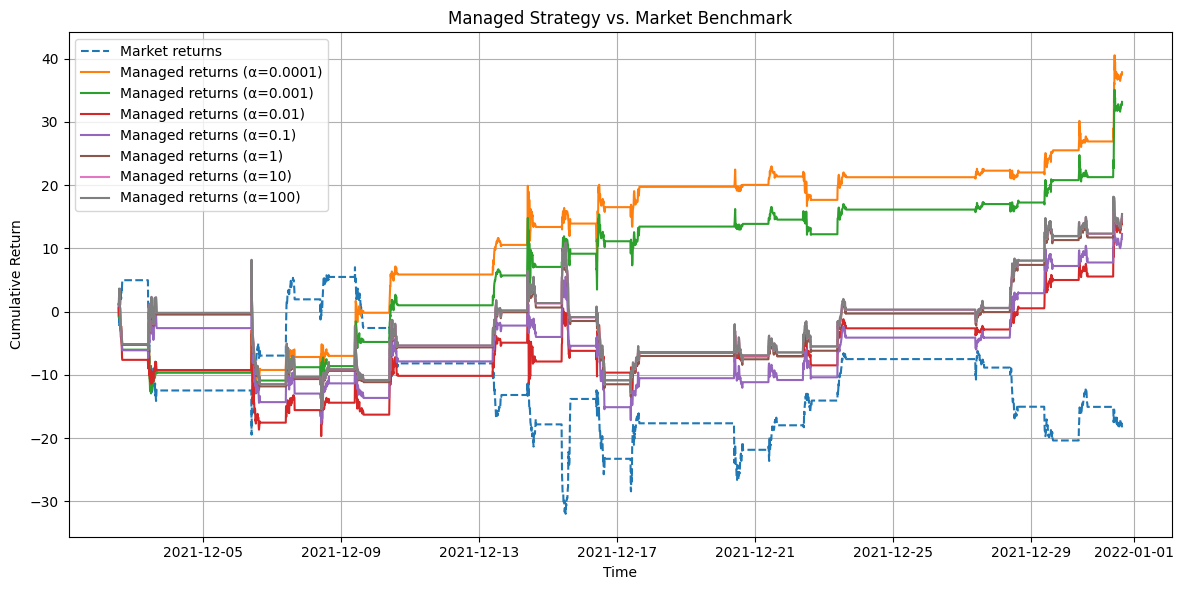

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(market_returns.cumsum(), label="Market returns", linestyle="--")

for alpha in shrinkage_list:

    plt.plot(
       managed_returns.cumsum()[('managed_return', alpha)],
       label=f"Managed returns (α={alpha})"
    )

plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Managed Strategy vs. Market Benchmark")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
print(sr)

y_true                     -0.08
(managed_return, 0.0001)    0.17
(managed_return, 0.001)     0.15
(managed_return, 0.01)      0.07
(managed_return, 0.1)       0.05
(managed_return, 1.0)       0.07
(managed_return, 10.0)      0.07
(managed_return, 100.0)     0.07
dtype: float64


# Ridge with random featuring
___

## Creating random stuff

In [31]:
functions = [
    lambda x: np.sin(x),
    lambda x: np.cos(x),
    lambda x: np.tan(x),
    lambda x: x**2,
    lambda x: np.abs(x),
    lambda x: np.sign(x),
]

In [32]:
# Creating std_deviation, skew, kurtosis columns for each lag
df_copy = table2.copy()

df_copy['lag_std'] = df_copy[lag_columns].std(axis=1)
df_copy['lag_skew'] = df_copy[lag_columns].skew(axis=1)
df_copy['lag_kurt'] = df_copy[lag_columns].kurt(axis=1)

# Features for regression
features = features + 'lag_std lag_skew lag_kurt'.split()

In [33]:
F = 200
# Creating random features coming from non-linear functions
split = int(F/2)

random_features = [f'feature_{feature}' for feature in range(F)]

feature_dict = {}

# Creating random features coming from non-linear functions
for feature in random_features[:split]:
    func = np.random.choice(functions)
    feature_dict[feature] = func(df_copy['return_lag_1'])

# Generate noise based on lagstd of each feature
noise_matrix = np.random.randn(len(df_copy), len(random_features[split:])) * df_copy['lag_std'].values[:, None]
noise_features = dict(zip(random_features[split:], noise_matrix.T))

all_features = {**feature_dict, **noise_features}

df_copy = pd.concat([df_copy, pd.DataFrame(all_features)], axis=1)

features = features + random_features


In [34]:
table2 = df_copy
del df_copy

## Running the ridge regression

In [35]:
# Run in parallel over all symbols
results = Parallel(n_jobs=-1)(
    delayed(run_ridge_for_symbol)(symbol, group, features=features, train_window= train_window, shrinkage_list=shrinkage_list)
    for symbol, group in tqdm.tqdm(table2.groupby("SYMBOL"))
)

# Flatten the nested list of predictions
results = [item for sublist in results for item in sublist]

# Convert to DataFrame
df_predictions = pd.DataFrame(results).set_index(['symbol', 'timestamp'])

100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


### Scores

In [36]:
r2 = r2_score(df_predictions['y_true'], df_predictions['y_pred'])
mae = mean_absolute_error(df_predictions['y_true'], df_predictions['y_pred'])

print(f"Overall R²: {r2:.4f}")
print(f"Overall MAE: {mae:.6f}")

Overall R²: -1.4637
Overall MAE: 0.003891


### Managed returns

In [37]:
# Market benchmark
df_predictions = df_predictions.reset_index()
df_market_returns = df_predictions.groupby('timestamp')['y_true'].mean()

# Our strategy returns
df_market_timing = df_predictions[['symbol','timestamp','alpha','y_pred','managed_return']]
df_market_timing = pd.pivot_table(df_market_timing, values=['managed_return'], index=['symbol', 'timestamp'],
                       columns=['alpha'], aggfunc="mean")
df_market_timing = df_market_timing.groupby(level=1).mean()

In [38]:
tmp = pd.concat([df_market_returns,df_market_timing], axis = 1)
tmp = tmp/tmp.std()
sr = sharpe_ratio(tmp)

In [39]:
market_returns = tmp['y_true']
managed_returns = tmp.iloc[:,1:]

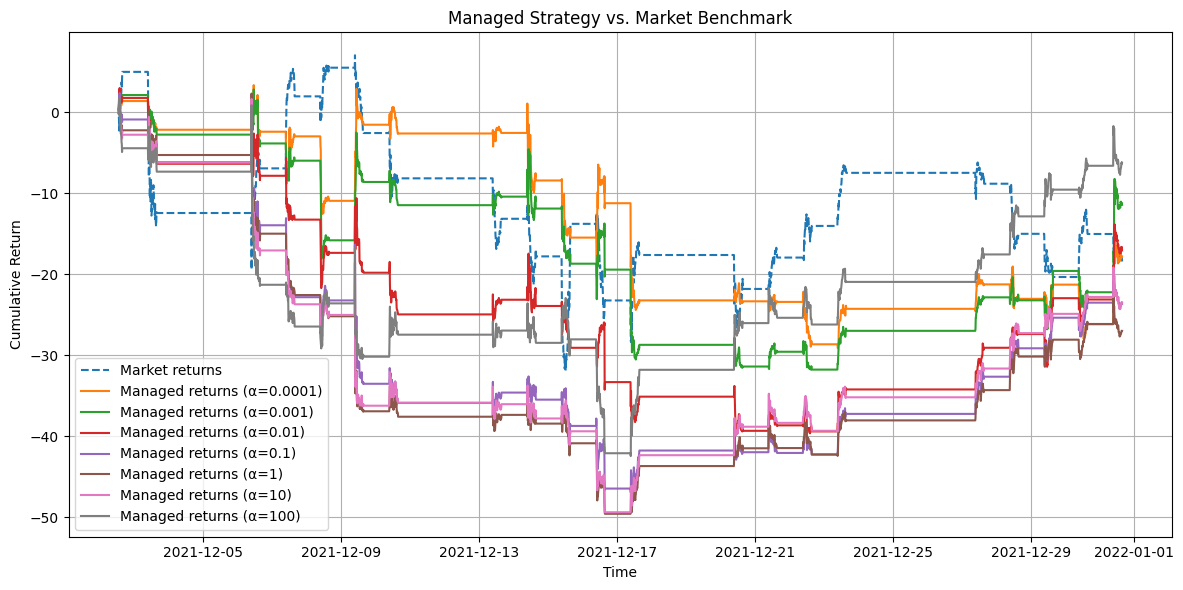

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(market_returns.cumsum(), label="Market returns", linestyle="--")

for alpha in shrinkage_list:

    plt.plot(
       managed_returns.cumsum()[('managed_return', alpha)],
       label=f"Managed returns (α={alpha})"
    )

plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Managed Strategy vs. Market Benchmark")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
print(sr)

y_true                     -0.08
(managed_return, 0.0001)   -0.08
(managed_return, 0.001)    -0.05
(managed_return, 0.01)     -0.08
(managed_return, 0.1)      -0.11
(managed_return, 1.0)      -0.12
(managed_return, 10.0)     -0.10
(managed_return, 100.0)    -0.03
dtype: float64
